# Academy Practicum 2

##  Galactic chemical evolution and stellar birth radii

---

### Summary

In this practicum we build a fully reproducible, observation-driven pipeline to study the chemical structure and evolution of the Galactic disk.

Using large modern surveys (APOGEE and Gaia), we demonstrate how Galactic archaeology proceeds from raw catalog data to physically meaningful conclusions. The practicum is organized in two complementary parts.

In Part I, we focus on the present-day structure of the Milky Way disk. By cross-matching APOGEE metallicities with Gaia astrometry, we construct a clean observational dataset and show that the Galactic disk exhibits a clear radial metallicity gradient. This gradient emerges directly from the data, without any model assumptions, highlighting the importance of statistical binning and careful visualization when working with large surveys.

In Part II, we introduce stellar ages derived from asteroseismically calibrated APOGEE samples (Boulet et al. 2024). The inclusion of ages allows us to move beyond static distributions and explore the time dimension of Galactic chemical evolution. We show that while the age–metallicity relation is highly scattered, systematic trends appear when analyzed statistically, pointing to inside-out disk growth and radial migration.

Throughout the practicum, emphasis is placed on methodology:
- all intermediate datasets are saved as CSV files,
- each analysis step is reproducible and modular,
- every figure can be regenerated independently of external services.

Practicum 2 establishes the observational foundation required to connect Galactic structure with physical models of disk formation and evolution, preparing the ground for subsequent reconstruction of stellar birth radii and quantitative tests of Galactic chemical evolution models.

### Motivation 

In Practicum 1, we established a clean observational foundation by
characterizing stellar samples and reconstructing stellar ages for
planet-hosting stars.

In this practicum, we move one step further and embed those stars into
their Galactic context.

The central goal of Practicum 2 is to connect stellar age and metallicity
to the large-scale chemical evolution of the Milky Way disk, and to use
this connection to reconstruct the **Galactocentric birth radii** of stars.

To achieve this, we proceed in two steps:
1. Use a large, homogeneous spectroscopic survey (APOGEE) to extract
   empirical chemo-age trends of the Galactic disk.
2. Use these trends as a physically motivated proxy for the time-dependent
   metallicity structure of the interstellar medium (ISM).

This framework allows us to translate observed stellar properties
(age, [Fe/H]) into a plausible Galactic formation environment.

----

### Cell 0. Notebook setup: paths and figure export

#### Purpose of this cell

This cell performs basic notebook initialization and defines a small utility that will be reused throughout the practical.
Its role is purely infrastructural: it does not perform any scientific computation or visualization yet.

Specifically, this cell:
1.	Finds the project root directory
The notebook may be executed from different subdirectories.
To make all paths robust and reproducible, we automatically walk up the directory tree until we find the folder named topics, which marks the project root.
2.	Defines the working directory for this practical
All outputs related to this practical (figures, animations, data products) are stored under
`topics/TOP_0001_exoplanet_birth_radius`.
3.	Creates a dedicated directory for exported figures
Figures generated in this notebook will be saved into a language-specific folder
(figures/en), which makes it easy to later export results to PDFs or reuse them in other products.
4.	Defines a helper function `save_fig()`
This function standardizes how figures are saved:
- consistent file format (`PNG`),
- consistent resolution (`DPI`),
- consistent layout (`bbox_inches="tight"`),
- and a single, predictable output location.

Using a helper function avoids repetitive boilerplate code and ensures that all figures
in the notebook are exported in a uniform way.

This setup allows us to focus on ideas and interpretation in later cells, without worrying about file paths or figure handling.

In [1]:
# =========================================================
# Cell 0 — Universal bootstrap (globals, paths, theme, i18n)
# Works for: ACAP_* and ANIM_*
# =========================================================

from __future__ import annotations

from pathlib import Path
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lulab.io.paths import (
    get_topic_root,
    figures_dir,
    data_raw_dir,
    data_processed_dir,
    animations_dir,
)
from lulab.io.save_figure import save_fig
import lulab.io.theme as th

# -----------------------------
# External services (Vizier)
# -----------------------------
from astroquery.vizier import Vizier

# No row limit by default
Vizier.ROW_LIMIT = -1

from tqdm import tqdm

# -----------------------------
# Global notebook constants
# -----------------------------
TOPIC: str = "TOP_0001_exoplanet_birth_radius"
NOTEBOOK: str = "ACAP_002"   # e.g. "ACAP_001", "ANIM_001"
LANG: str = "en"             # "en" / "ru"
THEME: str = "light"          # "light" / "dark"

# -----------------------------
# Animation export settings (safe to keep for ACAP too)
# -----------------------------
ANIM_FORMAT = "mp4"       # "gif" / "mp4"
FPS = 24
DPI = 200

MP4_CODEC = "libx264"
MP4_BITRATE = 1800

GIF_WRITER = "pillow"
GIF_LOOP = 0

# --- physical limits (keep consistent) ---
AGE_MIN_GYR = 0.1
AGE_MAX_GYR = 13.5
R_SUN = 8.0  # kpc

# -----------------------------
# Common paths
# -----------------------------
TOPIC_ROOT: Path = get_topic_root(TOPIC)
FIG_DIR: Path = figures_dir(TOPIC, lang=LANG, create=True)

DATA_RAW_DIR: Path = data_raw_dir(TOPIC, create=False)
DATA_PROCESSED_DIR: Path = data_processed_dir(TOPIC, create=True)

ANIM_DIR: Path = animations_dir(TOPIC, create=True)

# --- legacy aliases (do NOT remove, used in older cells) ---
RAW  = DATA_RAW_DIR
PROC = DATA_PROCESSED_DIR

# -----------------------------
# Theme
# -----------------------------
# Use a single consistent entry point everywhere
th.apply_theme(THEME)

# -----------------------------
# Save helpers
# -----------------------------
def save_fig0(fig_id: str, *, fig):
    """
    Save figure with notebook-scoped ID to avoid collisions.

    Example:
        save_fig0("Figure_3", fig=fig)
    -> build artifact ID:
        ANIM_001_Figure_3
    """
    full_id = f"{NOTEBOOK}_{fig_id}"
    return save_fig(full_id, fig=fig, topic=TOPIC, lang=LANG)

def anim_outpath(anim_id: str, ext: str | None = None) -> Path:
    """
    Standard output path for animations.
    Example:
        out = anim_outpath("Orbit_1")  -> ANIM_DIR/ANIM_001_Orbit_1.mp4
        out = anim_outpath("Orbit_1", ext="gif")
    """
    if ext is None:
        ext = ANIM_FORMAT
    return ANIM_DIR / f"{NOTEBOOK}_{anim_id}.{ext}"

# -----------------------------
# i18n bootstrap (force reload to avoid stale imports)
# -----------------------------
import lulab.i18n.plot_text as pt
importlib.reload(pt)

pt.set_lang(LANG)
if hasattr(pt, "set_notebook"):
    pt.set_notebook(NOTEBOOK)

pt.load_topic_i18n(TOPIC_ROOT, strict=True)

# convenience aliases (stable)
L = pt.L
T = pt.T

# -----------------------------
# Quick sanity printout
# -----------------------------
print("\n--- BOOTSTRAP ---")
print("TOPIC      :", TOPIC)
print("NOTEBOOK   :", NOTEBOOK)
print("LANG       :", LANG)
print("THEME      :", THEME)
print("TOPIC_ROOT :", TOPIC_ROOT)
print("FIG_DIR    :", FIG_DIR)
print("DATA_RAW   :", DATA_RAW_DIR)
print("DATA_PROC  :", DATA_PROCESSED_DIR)
print("ANIM_DIR   :", ANIM_DIR)
print("ANIM_FORMAT:", ANIM_FORMAT)
print("FPS / DPI  :", FPS, "/", DPI)


--- BOOTSTRAP ---
TOPIC      : TOP_0001_exoplanet_birth_radius
NOTEBOOK   : ACAP_002
LANG       : en
THEME      : light
TOPIC_ROOT : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius
FIG_DIR    : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en
DATA_RAW   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/raw
DATA_PROC  : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed
ANIM_DIR   : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/animations
ANIM_FORMAT: mp4
FPS / DPI  : 24 / 200


---

## Part I. Galactic chemical structure from APOGEE × Gaia

### 1.1. Goal of this part

In the first part of Practical Exercise 2, we aim to connect stellar chemistry, ages, and Galactic structure using large spectroscopic and astrometric surveys.

Specifically, we want to answer three closely related questions:
1. How does stellar metallicity [Fe/H] evolve with stellar age?
2. How does the metallicity distribution function (MDF) change with Galactocentric radius?
3. What is the present-day radial metallicity gradient of the Galactic disk?

These questions form the observational backbone of Galactic chemical evolution (GCE) models and motivate later parts of the practicum.


### 1.2. Data sources

We combine two complementary datasets:

1. APOGEE stellar spectroscopy
- Provides precise chemical abundances, in particular [Fe/H]
- Large, homogeneous sample of Milky Way disk stars

2. Gaia DR3 astrometry
- Provides parallaxes and sky positions
- Enables distances and Galactocentric radii

3. Boulet et al. (2024) APOGEE ages
- Asteroseismically calibrated stellar ages
- Used only for the age–metallicity relation
- This avoids the need for model-dependent age estimates in this practicum


### 1.3. Intermediate data products

To keep the workflow transparent and reproducible, all intermediate results are saved as explicit CSV files in the topic’s processed data directory.

Processed files produced in this part

| File name                 | Content                                                     | Purpose                               |
|---------------------------|-------------------------------------------------------------|----------------------------------------|
| `apogee_xmatch_raw.csv`   | Raw APOGEE × Gaia cross-match                               | Debugging / provenance                 |
| `apogee_ready.csv`        | Clean APOGEE × Gaia table (`ra`, `dec`, `feh`, `plx_mas`, `R_gal`, …) | Used for MDF and radial gradients      |
| `boulet_apogee_ages.csv`  | APOGEE stars with calibrated ages and `[Fe/H]`              | Used for age–metallicity relation      |


These files decouple data preparation from visualization, allowing the plotting cells to be lightweight and fast.


### 1.4. Data preprocessing pipeline

Conceptually, the data flow in this part of the practicum is:

![Data pipeline for ACAP 002](../assets/ACAP_002_EN_Data_Pipeline.png)

Two parallel but complementary tables are produced:
	•	one optimized for Galactic structure (apogee_ready.csv)
	•	one optimized for stellar ages (boulet_apogee_ages.csv)

They are intentionally not merged, to keep assumptions explicit.


### 1.5. What we do with the data

Using the processed tables, we construct a three-panel figure, each panel answering a specific physical question.

(a) Age vs [Fe/H]
- Input: boulet_apogee_ages.csv
- Scatter plot of stellar age versus metallicity
- A binned median highlights the global trend
- Reveals the chemical enrichment history of the disk

(b) Metallicity Distribution Function (MDF)
- Input: apogee_ready.csv
- Stars are split into Galactocentric radius bins (e.g. 6–8, 8–10, 10–12 kpc)
- MDFs are plotted horizontally for direct comparison
- Demonstrates the radial dependence of chemical enrichment

(c) R vs [Fe/H]
- Input: apogee_ready.csv
- Scatter plot of Galactocentric radius versus metallicity
- A linear fit yields the global radial metallicity gradient
- A reference line marks the approximate solar birth radius


### 1.6. Final visual output

All three panels are combined into a single, publication-style figure:
- Shared [Fe/H] axis for physical consistency
- Minimal but informative annotations
- Designed to resemble figures commonly found in GCE literature

The figure is saved using the project’s standardized pipeline, ensuring:
- consistent naming (ACAP_002_…)
- language-aware output directories
- reproducibility across notebooks


### 1.7. Why this structure matters

This design enforces several good scientific practices:
- Clear separation between data acquisition, processing, and visualization
- Explicit assumptions, especially regarding stellar ages
- Reusability of processed data for later exercises and animations
- Direct comparability with published Galactic chemical evolution studies

In the following parts of the practicum, these observational results will be interpreted in the context of radial migration and chemical evolution models.

### 1.8. APOGEE data Preprocessing

In [2]:
# === CELL: A2_APOGEE_PREP_VIZIER_XMATCH ===
import numpy as np
import pandas as pd
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from astropy import units as u
from io import StringIO

# =========================================================
# APOGEE × Gaia (DR3) prep  — RUN ONCE
# Produces:
#   1) apogee_xmatch_raw.csv   (full XMatch output for debugging)
#   2) apogee_ready.csv        (minimal clean table for all plots)
#
# Requires from bootstrap:
#   DATA_PROCESSED_DIR (Path)
# =========================================================

# -----------------------------
# Settings (tune)
# -----------------------------
VIZIER_ROW_LIMIT = 300_000
N_SAMPLE = 120_000
XMATCH_RADIUS = 1.0 * u.arcsec   # Quantity
RANDOM_SEED = 1

# Prefer APOGEE DR17 if available; keep your fallbacks too.
# (If the first doesn't work in your env, it will fall through.)
CANDIDATE_CATS = [
    "III/286/catalog",    # APOGEE DR17 (as you already use)
    "III/284/allstars",   # (fallback)
    "III/285/catalog",    # (fallback)
]

# Output filenames (single source of truth)
OUT_RAW   = "apogee_xmatch_raw.csv"
OUT_READY = "apogee_ready.csv"

# Parallax cuts (keep loose + consistent)
PLX_MIN_MAS = 0.1
PLX_MAX_MAS = 10.0

# -----------------------------
# 0) Helpers
# -----------------------------
def _pick_feh_col(cols):
    feh_candidates = ["[Fe/H]", "__Fe_H_", "Fe_H", "FE_H", "feh", "FEH"]
    for c in feh_candidates:
        if c in cols:
            return c
    feh_like = [c for c in cols if ("Fe/H" in c) or ("FE_H" in c) or ("Fe_H" in c)]
    return feh_like[0] if feh_like else None

def _pick_col(xm_cols, preferred, fallbacks_lower):
    # exact preferred first
    for c in preferred:
        if c in xm_cols:
            return c
    # then lower-case matching
    low = {c.lower(): c for c in xm_cols}
    for k in fallbacks_lower:
        if k in low:
            return low[k]
    return None

# -----------------------------
# 1) Load APOGEE-like table from VizieR
# -----------------------------
Vizier.ROW_LIMIT = VIZIER_ROW_LIMIT

ap_raw = None
used_cat = None
used_feh_col = None
last_err = None

for cat in CANDIDATE_CATS:
    try:
        print(f"Fetching APOGEE sample from VizieR: {cat} (ROW_LIMIT={VIZIER_ROW_LIMIT}) ...")
        tabs = Vizier.get_catalogs(cat)
        if len(tabs) == 0:
            continue

        t = tabs[0].to_pandas()

        if not {"RAJ2000", "DEJ2000"}.issubset(t.columns):
            print(f"  - skip {cat}: missing RAJ2000/DEJ2000")
            continue

        feh_col = _pick_feh_col(t.columns)
        if feh_col is None:
            print(f"  - skip {cat}: no [Fe/H]-like column found")
            continue

        ap_raw = t
        used_cat = cat
        used_feh_col = feh_col
        break

    except Exception as e:
        last_err = e
        print(f"  - error in {cat}: {e}")

if ap_raw is None:
    raise RuntimeError(
        f"Failed to load a usable APOGEE table from VizieR. Last error: {last_err}"
    )

print(f"\nUsing VizieR APOGEE catalog: {used_cat}")
print("Raw rows:", len(ap_raw))
print("Detected [Fe/H] column:", used_feh_col)

ap = (
    ap_raw.rename(columns={"RAJ2000": "ra", "DEJ2000": "dec", used_feh_col: "feh"})[
        ["ra", "dec", "feh"]
    ].copy()
)

# numeric coercion + clean
for col in ["ra", "dec", "feh"]:
    ap[col] = pd.to_numeric(ap[col], errors="coerce")

ap = ap.dropna(subset=["ra", "dec", "feh"]).copy()
print("Clean APOGEE rows:", len(ap))

if len(ap) > N_SAMPLE:
    ap = ap.sample(N_SAMPLE, random_state=RANDOM_SEED).reset_index(drop=True)
    print("Sampled APOGEE rows for xMatch:", len(ap))

# -----------------------------
# 2) CDS XMatch: upload APOGEE as CSV
# -----------------------------
print(
    f"Running CDS XMatch: APOGEE(upload) × I/355/gaiadr3 "
    f"(r={XMATCH_RADIUS.to_value(u.arcsec):.2f}\") ..."
)

csv_buf = StringIO()
ap.to_csv(csv_buf, index=False)
csv_buf.seek(0)

xm = XMatch.query(
    cat1=csv_buf,                 # file-like with .read()
    cat2="vizier:I/355/gaiadr3",
    max_distance=XMATCH_RADIUS,
    colRA1="ra",
    colDec1="dec",
).to_pandas()

print("XMatch rows returned:", len(xm))
print("XMatch columns (head):", list(xm.columns)[:25], "...")

# -----------------------------
# 3) Normalize to minimal schema used by plotting cells
# -----------------------------
# Gaia source id column often "Source"
src_col = _pick_col(
    xm.columns,
    preferred=["Source", "source_id", "gaia_id"],
    fallbacks_lower=["source", "source_id", "gaia_id", "dr3_source_id"],
)
# Parallax column often "Plx"
plx_col = _pick_col(
    xm.columns,
    preferred=["Plx", "parallax"],
    fallbacks_lower=["plx", "parallax"],
)

if src_col is None:
    raise RuntimeError(f"Could not find Gaia source id column. Columns: {list(xm.columns)}")
if plx_col is None:
    raise RuntimeError(f"Could not find Gaia parallax column. Columns: {list(xm.columns)}")
if "feh" not in xm.columns:
    raise RuntimeError("XMatch output is missing 'feh' column (should be carried from upload).")

apogee = xm.rename(columns={src_col: "gaia_id", plx_col: "plx_mas"})[
    ["ra", "dec", "gaia_id", "feh", "plx_mas"]
].copy()

# numeric coercion
apogee["gaia_id"] = pd.to_numeric(apogee["gaia_id"], errors="coerce")
apogee["plx_mas"] = pd.to_numeric(apogee["plx_mas"], errors="coerce")
apogee["feh"] = pd.to_numeric(apogee["feh"], errors="coerce")
apogee["ra"] = pd.to_numeric(apogee["ra"], errors="coerce")
apogee["dec"] = pd.to_numeric(apogee["dec"], errors="coerce")

apogee = apogee.dropna(subset=["gaia_id", "plx_mas", "feh", "ra", "dec"]).copy()

# gaia_id as int64
apogee["gaia_id"] = apogee["gaia_id"].astype(np.int64)

# basic parallax cuts
apogee = apogee[
    (apogee["plx_mas"] > 0) &
    (apogee["plx_mas"] >= PLX_MIN_MAS) &
    (apogee["plx_mas"] <= PLX_MAX_MAS)
].copy()

print("\nFinal `apogee` DataFrame ready.")
print("Rows:", len(apogee))
print("Columns:", list(apogee.columns))
display(apogee.head())

# -----------------------------
# 4) Save outputs for downstream cells
# -----------------------------
out_dir = DATA_PROCESSED_DIR
out_dir.mkdir(parents=True, exist_ok=True)

out_raw = out_dir / OUT_RAW
out_ready = out_dir / OUT_READY

# Save full xmatch table (debug/reference)
xm.to_csv(out_raw, index=False)

# Save the clean minimal table (used by ALL plots below)
apogee.to_csv(out_ready, index=False)

print("\nSaved:")
print(" -", out_raw)
print(" -", out_ready)
print("\nNOTE: Downstream plotting cells should now `pd.read_csv(out_ready)` and NOT rebuild XMatch.")

Could not import regions, which is required for some of the functionalities of this module.
Fetching APOGEE sample from VizieR: III/286/catalog (ROW_LIMIT=300000) ...

Using VizieR APOGEE catalog: III/286/catalog
Raw rows: 300000
Detected [Fe/H] column: [Fe/H]
Clean APOGEE rows: 259564
Sampled APOGEE rows for xMatch: 120000
Running CDS XMatch: APOGEE(upload) × I/355/gaiadr3 (r=1.00") ...
XMatch rows returned: 116320
XMatch columns (head): ['angDist', 'ra', 'dec', 'feh', 'DR3Name', 'RAdeg', 'DEdeg', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'SolID', 'Source', 'RandomI', 'e_RAdeg', 'e_DEdeg', 'Plx', 'e_Plx', 'RPlx', 'PM', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'RADEcor', 'RAPlxcor'] ...

Final `apogee` DataFrame ready.
Rows: 103606
Columns: ['ra', 'dec', 'gaia_id', 'feh', 'plx_mas']


,ra,dec,gaia_id,feh,plx_mas
0,102.808669,-3.926176,3102392733471646592,-0.2503,0.5660
1,55.832592,19.945875,63125990504192768,-0.5453,0.3404
2,29.709129,48.520287,356748062441880960,-0.2968,0.4402
3,60.891225,11.380289,3304564918630090624,-0.0061,6.3857
4,96.339634,12.644308,3331490893244407296,-0.5358,0.1978



Saved:
 - /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/apogee_xmatch_raw.csv
 - /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/apogee_ready.csv

NOTE: Downstream plotting cells should now `pd.read_csv(out_ready)` and NOT rebuild XMatch.


### 1.9 Adding distance and R_gal to apogee data

In [3]:
# =========================================================
# [ACAP_002|DATA_ISM] Build `m` (APOGEE×Gaia + dist_kpc + R_gal)
#
# Input:
#   - apogee_ready.csv  (produced by your APOGEE prep cell)
#
# Output:
#   - m DataFrame with columns: ra, dec, gaia_id, feh, plx_mas, dist_kpc, R_gal
#   - saved CSV: apogee_gaia_fehr_R.csv   (for plots + animation notebooks)
# =========================================================

import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

apogee_ready_path = DATA_PROCESSED_DIR / "apogee_ready.csv"
out_path = DATA_PROCESSED_DIR / "apogee_gaia_fehr_R.csv"

apogee = pd.read_csv(apogee_ready_path)

need = {"ra", "dec", "gaia_id", "feh", "plx_mas"}
missing = need - set(apogee.columns)
if missing:
    raise KeyError(f"apogee_ready.csv missing columns: {missing}. Has: {list(apogee.columns)}")

m = apogee.copy()

# numeric safety
for c in ["ra", "dec", "feh", "plx_mas"]:
    m[c] = pd.to_numeric(m[c], errors="coerce")
m = m.dropna(subset=["ra", "dec", "feh", "plx_mas"]).copy()

# distance in kpc: parallax in mas => distance(pc) = 1000/plx_mas => kpc = 1/plx_mas
# (you already applied loose plx cuts in prep cell; keep a final guard)
m = m[(m["plx_mas"] > 0)].copy()
m["dist_kpc"] = 1.0 / m["plx_mas"]

# compute Galactocentric radius in the disk plane (R_gal)
# Geometry:
#   d_xy = d * cos(b)
#   R = sqrt(Rsun^2 + d_xy^2 - 2*Rsun*d_xy*cos(l))
coords = SkyCoord(
    ra=m["ra"].to_numpy() * u.deg,
    dec=m["dec"].to_numpy() * u.deg,
    distance=m["dist_kpc"].to_numpy() * u.kpc,
    frame="icrs",
)
gal = coords.galactic
l = gal.l.to_value(u.rad)
b = gal.b.to_value(u.rad)
d = m["dist_kpc"].to_numpy(dtype=float)
d_xy = d * np.cos(b)

Rsun = float(R_SUN)  # from bootstrap, kpc
m["R_gal"] = np.sqrt(np.maximum(0.0, Rsun**2 + d_xy**2 - 2.0 * Rsun * d_xy * np.cos(l)))

# final cleanup (optional but useful)
m = m.replace([np.inf, -np.inf], np.nan).dropna(subset=["dist_kpc", "R_gal", "feh"]).copy()

# save (this is what animation notebooks should use too)
m.to_csv(out_path, index=False)

print("m ready + saved.")
print("Path :", out_path)
print("Rows :", len(m))
print("Cols :", list(m.columns))
display(m.head())

m ready + saved.
Path : /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/apogee_gaia_fehr_R.csv
Rows : 103606
Cols : ['ra', 'dec', 'gaia_id', 'feh', 'plx_mas', 'dist_kpc', 'R_gal']


,ra,dec,gaia_id,feh,plx_mas,dist_kpc,R_gal
0,102.808669,-3.926176,3102392733471646592,-0.2503,0.5660,1.766784,9.479378
1,55.832592,19.945875,63125990504192768,-0.5453,0.3404,2.937720,10.577425
2,29.709129,48.520287,356748062441880960,-0.2968,0.4402,2.271695,9.677240
3,60.891225,11.380289,3304564918630090624,-0.0061,6.3857,0.156600,8.136204
4,96.339634,12.644308,3331490893244407296,-0.5358,0.1978,5.055612,12.890503


### 1.10. Establishing Age-metallicity relation with Boulet dataset 

In [4]:
# =========================================================
# DATA_AGE — Boulet+2024 ages (APOGEE DR17, VizieR) -> df_age + CSV cache
# =========================================================

import numpy as np
import pandas as pd

OUT_AGE = DATA_PROCESSED_DIR / "boulet_apogee_ages.csv"

def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

if OUT_AGE.exists():
    df_age = pd.read_csv(OUT_AGE)
    print("Loaded cached:", OUT_AGE, "| rows:", len(df_age))
else:
    Vizier.ROW_LIMIT = -1
    cat = "J/A+A/685/A66"   # Boulet 2024 ages for APOGEE DR17
    t = Vizier.get_catalogs(cat)[0].to_pandas()
    print("Fetched:", cat, "| rows:", len(t))
    print("Columns(head):", list(t.columns)[:40])

    # --- try to find Gaia source id
    gaia_col = pick_col(t, ["Source", "source_id", "GaiaDR3", "GaiaEDR3", "Gaia", "GAIAEDR3", "GAIADR3"])

    # --- age column candidates (depends on catalog schema)
    age_gyr_col = pick_col(t, ["Age", "age", "AgeGyr", "age_gyr", "AGE_GYR", "t_gyr"])
    logage_col  = pick_col(t, ["logAge", "log_age", "logt", "logAge_yr", "logAgeYr"])

    # --- metallicity candidates
    feh_col = pick_col(t, ["[Fe/H]", "FeH", "feh", "__Fe_H_", "FE_H", "Fe_H"])

    if feh_col is None:
        raise RuntimeError("Cannot find [Fe/H] column in Boulet table. Check columns print above.")

    if (age_gyr_col is None) and (logage_col is None):
        raise RuntimeError("Cannot find age column (Age in Gyr or logAge). Check columns print above.")

    df_age = pd.DataFrame()
    if gaia_col is not None:
        df_age["gaia_id"] = pd.to_numeric(t[gaia_col], errors="coerce")

    df_age["feh"] = pd.to_numeric(t[feh_col], errors="coerce")

    if age_gyr_col is not None:
        df_age["age"] = pd.to_numeric(t[age_gyr_col], errors="coerce")
    else:
        # assume log10(age/yr)
        logage = pd.to_numeric(t[logage_col], errors="coerce")
        df_age["age"] = (10 ** logage) / 1e9

    # basic cleanup
    keep = ["age", "feh"] + (["gaia_id"] if "gaia_id" in df_age.columns else [])
    df_age = df_age[keep].dropna().copy()

    OUT_AGE.parent.mkdir(parents=True, exist_ok=True)
    df_age.to_csv(OUT_AGE, index=False)
    print("Saved:", OUT_AGE, "| rows:", len(df_age))

df_age.head()

Loaded cached: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/boulet_apogee_ages.csv | rows: 125445


,age,feh,gaia_id
0,5.77,-0.54,4342806982510019456
1,8.28,0.15,1158019050967480064
2,4.70,-0.24,1159422749358899072
3,8.60,-0.91,4131550666634133888
4,6.11,-0.04,4110973989419352704


### 1.11. Graph Chemical age structure of the Galactic disk

The figure below summarizes the key chemo-age properties of the `APOGEE`
disk sample.

The three panels illustrate complementary projections of the same
stellar population and together capture the essential empirical trends
needed for our analysis.

df_age rows: 125445
ISM rows   : 103606


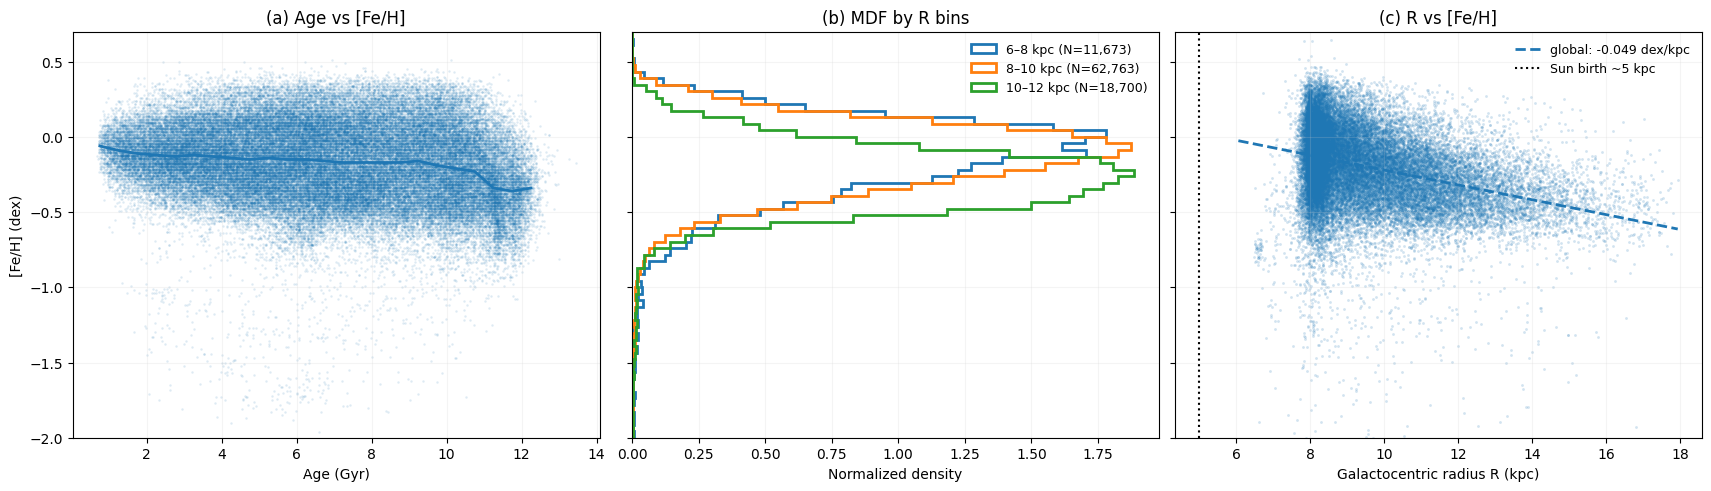

Global gradient d[Fe/H]/dR = -0.049 dex/kpc
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_002_Figure_1.png


PosixPath('/Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_002_Figure_1.png')

In [5]:
# =========================================================
# FIG_APOGEE_PANEL — 3-panel summary (Boulet+2024 ages + APOGEE×Gaia ISM)
#   (a) Age vs [Fe/H]  (Boulet+2024)
#   (b) MDF by R bins  (ISM sample, rotated)
#   (c) R vs [Fe/H] + global gradient + Solar birth marker
# =========================================================

# CELL: ACAP_002_APOGEE_MAIN_PANEL
# Data: Boulet+2024 APOGEE ages + Gaia DR3 geometry

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lulab.i18n.plot_text import L, T

# -----------------------------
# Inputs (from bootstrap)
# -----------------------------
# df_age should exist from DATA_AGE cell
if "df_age" not in globals():
    raise RuntimeError("DataFrame `df_age` not found. Run DATA_AGE cell first (Boulet+2024).")

# ISM dataframe for R_gal etc.
ism_path = DATA_PROCESSED_DIR / "apogee_gaia_fehr_R.csv"
if not ism_path.exists():
    raise FileNotFoundError(
        f"Missing ISM CSV: {ism_path}\n"
        "Run the ISM construction cell(s) that create R_gal/dist_kpc and save this file."
    )

m = pd.read_csv(ism_path)

# -----------------------------
# Normalize schemas
# -----------------------------
# df_age: ensure columns [age, feh]
if "age" not in df_age.columns:
    if "Age" in df_age.columns:
        df_age = df_age.rename(columns={"Age": "age"})
    else:
        raise KeyError(f"df_age missing age column. Columns: {list(df_age.columns)}")

if "feh" not in df_age.columns:
    if "[Fe/H]" in df_age.columns:
        df_age = df_age.rename(columns={"[Fe/H]": "feh"})
    else:
        raise KeyError(f"df_age missing feh column. Columns: {list(df_age.columns)}")

# ISM table: ensure columns [R_gal, feh] (plus optional dist_kpc)
if "feh" not in m.columns:
    if "[Fe/H]" in m.columns:
        m = m.rename(columns={"[Fe/H]": "feh"})
    else:
        raise KeyError(f"ISM table missing feh column. Columns: {list(m.columns)}")

if "R_gal" not in m.columns:
    raise KeyError(f"ISM table missing R_gal. Columns: {list(m.columns)}")

# numeric coercion
for col in ["age", "feh"]:
    df_age[col] = pd.to_numeric(df_age[col], errors="coerce")

for col in ["R_gal", "feh"]:
    m[col] = pd.to_numeric(m[col], errors="coerce")

# -----------------------------
# Cuts (use bootstrap constants)
# -----------------------------
df_age = df_age.dropna(subset=["age", "feh"]).copy()
df_age = df_age[(df_age["age"] >= AGE_MIN_GYR) & (df_age["age"] <= AGE_MAX_GYR)].copy()

m = m.dropna(subset=["R_gal", "feh"]).copy()
m = m[(m["R_gal"] >= 0.0) & (m["R_gal"] <= 30.0)].copy()  # loose safety

print("df_age rows:", len(df_age))
print("ISM rows   :", len(m))

# -----------------------------
# Helpers
# -----------------------------
def binned_median(x, y, bins, min_count=200):
    x = np.asarray(x); y = np.asarray(y)
    idx = np.digitize(x, bins) - 1
    xc, yc = [], []
    for i in range(len(bins) - 1):
        sel = idx == i
        if sel.sum() < min_count:
            continue
        xc.append(0.5 * (bins[i] + bins[i+1]))
        yc.append(np.nanmedian(y[sel]))
    return np.array(xc), np.array(yc)

# -----------------------------
# Shared styling
# -----------------------------
FEH_MIN, FEH_MAX = -2.0, 0.7
FEH_TICKS = np.arange(-2.0, 0.8, 0.5)

SOLAR_BIRTH_R = 5.0  # kpc (narrative marker)

# -----------------------------
# Figure
# -----------------------------
fig, axes = plt.subplots(
    1, 3, figsize=(17, 4.8),
    constrained_layout=True, sharey=True
)

# =========================
# (a) Age vs [Fe/H]  (Boulet+2024)
# =========================
ax = axes[0]
samp_a = df_age.sample(min(len(df_age), 80000), random_state=1)
ax.scatter(samp_a["age"], samp_a["feh"], s=3, alpha=0.15, linewidths=0)

age_bins = np.linspace(0, 14, 29)  # 0.5 Gyr bins (presentation)
xmed, ymed = binned_median(df_age["age"], df_age["feh"], age_bins, min_count=300)
if len(xmed) > 0:
    ax.plot(xmed, ymed, lw=2)

ax.set_xlabel(L("age_gyr"))             # "Age (Gyr)" / "Возраст ..."
ax.set_ylabel(L("feh"))                 # "[Fe/H] (dex)" (ok)
ax.set_title(T("apogee_panel_left"))    # from titles.yaml
ax.set_ylim(FEH_MIN, FEH_MAX)
ax.set_yticks(FEH_TICKS)
ax.grid(alpha=0.2)

# =========================
# (b) MDF by R bins (rotated)
# =========================
ax = axes[1]
feh_bins = np.linspace(FEH_MIN, 1.0, 70)
radial_bins = [(6, 8), (8, 10), (10, 12)]

for r1, r2 in radial_bins:
    sel = (m["R_gal"] >= r1) & (m["R_gal"] < r2)
    n = int(sel.sum())
    if n < 2000:
        continue
    ax.hist(
        m.loc[sel, "feh"],
        bins=feh_bins, density=True,
        histtype="step", lw=2,
        orientation="horizontal",
        label=f"{r1}–{r2} kpc (N={n:,})"
    )

ax.set_xlabel(L("density"))
ax.set_title(T("apogee_panel_mid"))
ax.set_ylim(FEH_MIN, FEH_MAX)
ax.set_yticks(FEH_TICKS)
ax.legend(frameon=False, fontsize=9)
ax.grid(alpha=0.2)

# =========================
# (c) R vs [Fe/H] + gradient + solar marker
# =========================
ax = axes[2]
samp_c = m.sample(min(len(m), 40000), random_state=1)
ax.scatter(samp_c["R_gal"], samp_c["feh"], s=4, alpha=0.2, linewidths=0)

coef = np.polyfit(m["R_gal"].values, m["feh"].values, 1)
xfit = np.linspace(m["R_gal"].min(), m["R_gal"].max(), 300)
ax.plot(xfit, coef[0] * xfit + coef[1], lw=2, linestyle="--",
        label=f"global: {coef[0]:.3f} dex/kpc")

ax.axvline(SOLAR_BIRTH_R, color="k", lw=1.5, ls=":", label="Sun birth ~5 kpc")

ax.set_xlabel(L("R_gal"))
ax.set_title(T("apogee_panel_right"))
ax.set_ylim(FEH_MIN, FEH_MAX)
ax.set_yticks(FEH_TICKS)
ax.legend(frameon=False, fontsize=9)
ax.grid(alpha=0.2)

# remove duplicate y labels (paper-style)
axes[1].set_ylabel("")
axes[2].set_ylabel("")

plt.show()
print(f"Global gradient d[Fe/H]/dR = {coef[0]:.3f} dex/kpc")

save_fig0("Figure_1", fig=fig)

### 1.12. Interpretation

Several robust features are immediately apparent:

- The age–metallicity relation exhibits large intrinsic scatter,
  indicating that stellar metallicity alone is not a reliable age proxy.
- Older stars are, on average, more metal-poor, but span a wide range
  of [Fe/H], reflecting radial migration and the inside-out growth of
  the Galactic disk.
- The radial metallicity gradient is negative and evolves with time,
  becoming steeper at early epochs and flatter at late times.

These empirical trends provide the physical motivation for modeling the
ISM metallicity as a function of both Galactocentric radius and time.

In the following sections, we use these APOGEE-based trends to construct
simple, physically motivated Galactic chemical evolution prescriptions.

### 1.13 Conclusion of Part I

In this practicum we have constructed a fully reproducible, observation-driven pipeline for studying Galactic chemical structure:
- All raw queries and cross-matches are explicit and saved to disk
- Intermediate and final datasets are stored as CSV files
- Every plot can be regenerated independently of external services

Using APOGEE × Gaia data, we demonstrated that:
- The Galactic disk exhibits a clear radial metallicity gradient
- The gradient emerges directly from observations, without any model assumptions
- Statistical binning and careful visualization are essential for interpreting large surveys

This observational foundation is crucial for the next steps, where we will:
- Compare present-day metallicity structure with stellar ages
- Infer stellar birth radii
- Connect observational trends to physical models of Galactic evolution

*In the next part of Practicum 2, we will extend this static picture by incorporating stellar ages, allowing us to probe the time evolution of the Galactic metallicity gradient and the role of stellar migration.*

---

## Part II. ([Fe/H] vs Galactocentric radius with binned statistics)

### 2.1. What we build and why

In this part of the practicum we aim to characterize the large-scale metallicity structure of the Galactic disk using a homogeneous spectroscopic sample.

Specifically, we want to answer:
- How does stellar metallicity [Fe/H] vary with Galactocentric radius?
- Is the radial metallicity gradient clearly visible in a purely observational dataset?
- How robust is the trend when accounting for sampling biases and uneven spatial coverage?

This diagnostic is a cornerstone of Galactic chemical evolution (GCE) studies and provides an observational anchor for interpreting stellar birth radii and migration effects in later steps.


### 2.2. Data sources

We use a cross-matched APOGEE × Gaia dataset, prepared earlier in this notebook:
- APOGEE: high-resolution spectroscopy → precise [Fe/H]
- Gaia DR3: astrometry → distances and Galactic geometry

The input file for this figure is:

`data/processed/apogee_gaia_fehr_R.csv`

which contains, at minimum, the following columns:
- `feh` — stellar metallicity [Fe/H] (dex)
- `R_gal` — Galactocentric radius (kpc)

All intermediate steps (`VizieR` query, `Gaia` cross-match, distance computation) are explicitly saved to `CSV`, ensuring full reproducibility.

Loaded ISM table: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/data/processed/apogee_gaia_fehr_R.csv
Rows for diagnostics: 103606
Bins: 40
Bins with N >= 400: 16
Min/Max N in bins: 0 34361
Saved figure: /Users/mloktionov/PycharmProjects/Stellar_Attractor/attractor-lab/topics/TOP_0001_exoplanet_birth_radius/figures/en/ACAP_002_Figure_2.png


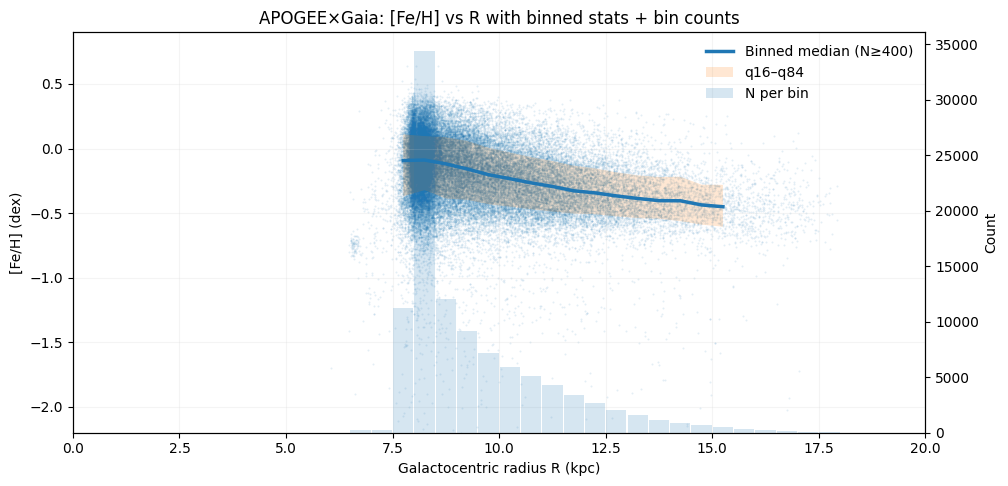

In [6]:
# =========================================================
# [ACAP_002|FIG_ISM] APOGEE×Gaia: [Fe/H] vs R_gal with binned stats + bin counts
#
# Input:
#   - apogee_gaia_fehr_R.csv  (produced in [ACAP_002|DATA_ISM])
#
# Output:
#   - Figure saved via save_fig0(...)
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lulab.i18n.plot_text import L, T

# ----------------------------
# Load standardized ISM table
# ----------------------------
ism_path = DATA_PROCESSED_DIR / "apogee_gaia_fehr_R.csv"
df = pd.read_csv(ism_path)

need = {"R_gal", "feh"}
missing = need - set(df.columns)
if missing:
    raise RuntimeError(
        f"Missing columns {missing} in {ism_path.name}. "
        f"Found columns: {list(df.columns)}"
    )

df = df[["R_gal", "feh"]].copy()
df["R_gal"] = pd.to_numeric(df["R_gal"], errors="coerce")
df["feh"]   = pd.to_numeric(df["feh"], errors="coerce")
df = df.dropna(subset=["R_gal", "feh"])

# presentation-safe limits (keep wide; tune if needed)
df = df[(df["R_gal"] > 0) & (df["R_gal"] < 30) & (df["feh"] > -3) & (df["feh"] < 1.5)].copy()

print("Loaded ISM table:", ism_path)
print("Rows for diagnostics:", len(df))

# ----------------------------
# Binning config
# ----------------------------
R_MIN, R_MAX = 0.0, 20.0
BIN_W = 0.5            # kpc
MIN_N = 400            # show median/band only if bin has >= MIN_N

bins = np.arange(R_MIN, R_MAX + BIN_W, BIN_W)
cent = 0.5 * (bins[:-1] + bins[1:])

# ----------------------------
# Compute binned stats
# ----------------------------
idx = np.digitize(df["R_gal"].to_numpy(), bins) - 1
valid = (idx >= 0) & (idx < len(cent))
idx = idx[valid]
feh = df["feh"].to_numpy()[valid]

N   = np.bincount(idx, minlength=len(cent)).astype(int)

med = np.full(len(cent), np.nan, dtype=float)
q16 = np.full(len(cent), np.nan, dtype=float)
q84 = np.full(len(cent), np.nan, dtype=float)

for i in range(len(cent)):
    if N[i] == 0:
        continue
    vals = feh[idx == i]
    med[i] = np.nanmedian(vals)
    q16[i] = np.nanpercentile(vals, 16)
    q84[i] = np.nanpercentile(vals, 84)

mask = N >= MIN_N

print("Bins:", len(cent))
print(f"Bins with N >= {MIN_N}:", int(mask.sum()))
if len(N) > 0:
    print("Min/Max N in bins:", int(N.min()), int(N.max()))

# ----------------------------
# Plot: median + quantiles + N bars on twin axis
# ----------------------------
fig, ax = plt.subplots(figsize=(11, 5.2))

# scatter subsample for context
samp = df.sample(min(len(df), 60000), random_state=1) if len(df) > 0 else df
ax.scatter(samp["R_gal"], samp["feh"], s=2, alpha=0.12, linewidths=0)

# binned median & band
ax.plot(
    cent[mask], med[mask],
    linewidth=2.5,
    label=f"{L('binned_median')} (N≥{MIN_N})" if L("binned_median") != "binned_median" else f"Binned median (N≥{MIN_N})"
)
ax.fill_between(
    cent[mask], q16[mask], q84[mask],
    alpha=0.18,
    label=L("q16_q84") if L("q16_q84") != "q16_q84" else "q16–q84"
)

ax.set_xlim(R_MIN, R_MAX)
ax.set_ylim(-2.2, 0.9)
ax.set_xlabel(L("R_gal"))   # "Galactocentric radius R (kpc)" / RU version in YAML
ax.set_ylabel(L("feh"))     # "[Fe/H] (dex)" (same in both)
ax.grid(alpha=0.2)

# twin axis for counts
ax2 = ax.twinx()
ax2.bar(cent, N, width=BIN_W * 0.95, alpha=0.18, label=L("n_per_bin") if L("n_per_bin") != "n_per_bin" else "N per bin")
ax2.set_ylabel(L("count"))  # "Count"/"Количество" (close enough for N-axis)
ax2.set_ylim(0, max(N.max() * 1.05, 1))

# combined legend
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, frameon=False, loc="upper right")

ax.set_title(T("figure_ism_feh_vs_Rgal") if T("figure_ism_feh_vs_Rgal") != "figure_ism_feh_vs_Rgal"
             else "APOGEE×Gaia: [Fe/H] vs R with binned stats + bin counts")

# save
save_fig0("Figure_2", fig=fig)
plt.show()

*Figure 2. “The present-day radial metallicity gradient inferred from APOGEE×Gaia stars is shallow ($\sim\;-0.05\;\mathrm{dex}\;\mathrm{kpc}^{-1}$), consistent with strong radial mixing.*

*Chemo-dynamical reconstructions and young tracers indicate that the intrinsic ISM gradient at birth was significantly steeper ($\sim -0.2$ to $-0.3\;\mathrm{dex\;kpc}^{-1}$), implying substantial flattening over Galactic time.”*


### 2.3 What is shown on the figure

The figure combines three complementary layers:
1.	Scatter cloud (background)
A large subsample of individual stars, showing the full dispersion of [Fe/H] at each radius.
This highlights intrinsic scatter, selection effects, and population mixing.

2.	Binned statistics (foreground)
- The median [Fe/H] in radial bins of width ΔR = 0.5 kpc
- Shaded q16–q84 interval (≈1σ equivalent)
- Only bins with sufficient statistics (N ≥ 400) are shown, avoiding noise-dominated regions

3.	Per-bin star counts (secondary axis)
A histogram of the number of stars contributing to each radial bin, visualizing where the dataset is statistically reliable.

### 2.4 What we learn from this plot
1.	A clear negative radial metallicity gradient
The median [Fe/H] decreases steadily with increasing Galactocentric radius, consistent with classical disk GCE expectations.

2.	Maximum statistical weight near the Solar circle
The star counts peak around R ≈ 8 kpc, reflecting both survey strategy and Solar-neighborhood geometry.

3.	Increasing scatter at larger radii
The outer disk shows broader [Fe/H] dispersion, likely due to a combination of:
- Radial migration
- Lower star-formation efficiency
- Stronger selection effects

4.	Robustness against outliers
Using medians and quantiles instead of means makes the trend stable even in the presence of metal-poor tails and survey artifacts.

This plot provides the observational backbone for interpreting stellar birth radii and motivates the modeling steps introduced in later practica.

---


### 2.5 Conclusions for Part II

(From observational trends to Galactic evolution)

In the second part of this practicum, we extended the purely observational picture of the Galactic disk by incorporating stellar ages derived from asteroseismically calibrated APOGEE data (Boulet et al. 2024).

By combining:
- stellar ages,
- metallicities,
- and Galactic positions,

we were able to move beyond static distributions and explore the time dimension of Galactic chemical evolution.

Key results of this part include:
- The age–metallicity relation exhibits large intrinsic scatter, confirming that metallicity alone is a poor age indicator for disk stars.
-  Despite this scatter, systematic trends emerge when data are binned and analyzed statistically.
- The observed radial metallicity gradient is consistent with a scenario in which stars formed at different Galactocentric radii and later migrated.
- The present-day metallicity structure of the disk cannot be explained without accounting for temporal evolution and stellar redistribution.

This part demonstrates that ages are the critical missing link between present-day Galactic structure and its formation history.

They allow us to connect observed metallicity patterns to physical processes such as inside-out disk growth and radial migration.

### Final Conclusion — Practicum 2

(Observational foundations of Galactic chemical evolution)

In Practicum 2 we constructed a complete, observation-driven pipeline for studying the chemical structure and evolution of the Galactic disk.

Starting from large spectroscopic and astrometric surveys (`APOGEE` and `Gaia`), we demonstrated how modern Galactic archaeology proceeds from raw catalog data to physical interpretation.

Across both parts of the practicum, we showed that:
- The Milky Way disk exhibits a clear, statistically robust radial metallicity gradient.
- This gradient is directly observable and does not depend on model assumptions.
- Stellar ages reveal that the metallicity structure of the disk is not static, but evolves over time.
- The combination of ages, metallicities, and positions provides strong evidence for radial migration and inside-out disk formation.

Equally important, this practicum emphasized methodology:
- All data products are reproducible and stored as intermediate CSV files.
- Each analysis step can be rerun independently of external services.
- Visualization choices and statistical binning critically shape the scientific conclusions.

Practicum 2 thus establishes the observational and methodological foundation for the next stage of analysis, where physically motivated Galactic chemical evolution models can be confronted with data.

In the following practicums, these observational constraints will be used to:
- reconstruct stellar birth radii,
- test competing evolutionary models,
- and ultimately link present-day Galactic structure to the Milky Way’s formation history.

## References
